# Laboratorio 2 - Clasificacion de rotulos de trafico utilizando CNN Le-Net

#### Brandon Sicay - 21757
#### Daniel Morales - 


### *1. Preparación de datos:*  

In [13]:
!pip install -U scikit-learn scipy 


In [1]:
import os
import pandas as pd
import pickle
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.image import imread
from keras.models import Sequential
from keras.layers import Activation, Dropout, Flatten, Dense, Conv2D, MaxPooling2D
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping

/Users/brand/Downloads/lab3DS/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [2]:
train_route = './Datos_Rotulos_Trafico/entrenamiento.p'
test_route =  './Datos_Rotulos_Trafico/prueba.p'
validation_route = './Datos_Rotulos_Trafico/validacion.p'

In [3]:
train_data = pd.read_pickle(train_route)
test_data = pd.read_pickle(test_route)
validation_data = pd.read_pickle(validation_route)

In [4]:
train_images = train_data['features']
labels = train_data['labels']
test_features = test_data['features']
validation_features = validation_data['features']

In [6]:
(train_images.shape)
(labels.shape)
(test_features.shape)
(validation_features.shape)

(4410, 32, 32, 3)

In [7]:
from sklearn.model_selection import train_test_split

train_images = train_images.astype(np.float32) / 255.0

# Creacion de variables de entrenamiento, validacion y testeo. Contando imagenes y etiquetas
train_features, test_features, train_labels, test_labels = train_test_split(train_images, labels, test_size=0.2, random_state=42)
train_feautres, val_features, train_labels, val_labels = train_test_split(train_features, train_labels, test_size=0.2, random_state=42)


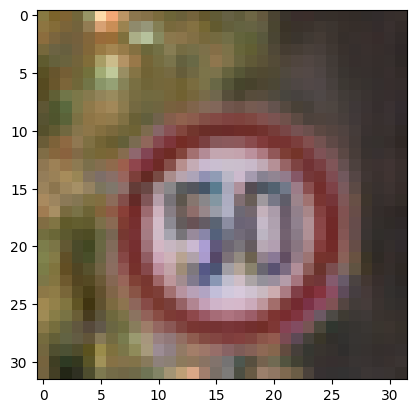

In [8]:
plt.imshow(train_features[0])
